Experiments with Rvachev normalization. PyTorch is used for computing the derivatives. Likely it should be rewritten with Jax, see the comment below. 

In [1]:
import torch
import math
from math import factorial
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [2]:
def gradient_unsafe(y, x, grad_outputs=None):
  if grad_outputs is None:
    grad_outputs = torch.ones_like(y)
  grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
  return grad

In [3]:
def gradient_safe(y, x, grad_outputs=None):
  if grad_outputs is None:
    grad_outputs = torch.ones_like(y)
  grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
  grad = torch.nan_to_num(grad)
  return grad

In [4]:
gradient = gradient_safe

In [5]:
def ellipse(p):
  x = p[:,0]
  y = p[:,1]
  d = 1.0 - (x / 5.0)**2 - (y / 3.0)**2
  return d

def thin_ellipse(p):
  x = p[:,0]
  y = p[:,1]
  d = 1.0 - (x / 16.9)**2 - (y / 0.5)**2
  return d

In [6]:
# Create a 2D grid as a torch tensor
def torch_grid(xmin, xmax, ymin, ymax, resx=64, resy=64, device='cpu'):
  dx = xmax - xmin
  dy = ymax - ymin

  ed = 0.1*math.sqrt(dx*dx+dy*dy)

  x = torch.arange(xmin-ed, xmax+ed, step=(dx+2*ed)/float(resx))
  y = torch.arange(ymin-ed, ymax+ed, step=(dy+2*ed)/float(resy))

  xx, yy = torch.meshgrid(x, y)

  return xx.to(device), yy.to(device)

In [7]:
# Sample function f() on torch 2D grid x,y
def torch_sampling(f, x, y, device='cpu'):
  nx = x.shape[0]
  ny = x.shape[1]
  d = nx * ny
  xy = torch.stack((x, y), dim=-1).reshape(d, 2)  
  z = f(xy)
  z = torch.reshape(z, (nx,ny))
  return z

In [8]:
def show_contour_plot(x, y, f): 
  xx = x.detach().numpy()
  yy = y.detach().numpy()
  ff = f.detach().numpy()
  plt.figure(figsize=(8,4))
  h = plt.contourf(xx, yy, ff)
  h.ax.axis('equal')
  plt.title('Filled Contour Plot')
  plt.show()

def show_contour_lines(x, y, f):
  xx = x.detach().numpy()
  yy = y.detach().numpy()
  ff = f.detach().numpy()
  plt.figure()
  levels = np.arange(-0.5, 0.1, 0.1)
  CS = plt.contour(xx, yy, ff, levels)
  CB = plt.colorbar(CS, shrink=0.8, extend='both')
  plt.title('Ellipse')
  plt.axis('equal')
  plt.show()

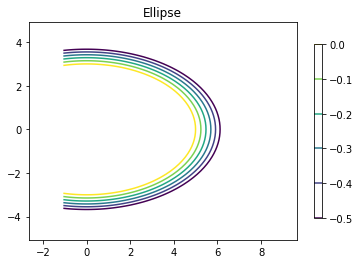

In [9]:
NX = 64
NY = 64
XMIN = 0.0
XMAX = 7.0
YMIN = -4.0
YMAX = 4.0

x,y = torch_grid(XMIN,XMAX,YMIN,YMAX,NX,NY)
f = torch_sampling(ellipse, x, y)
show_contour_lines(x, y, f)

In [10]:
def normalize(f, x, n):
  fx = f(x)
  gradf = gradient(fx, x)
  norm_gradf2 = gradf[:,0]**2 + gradf[:,1]**2
  norm_gradf = torch.sqrt(norm_gradf2)
  #normal = gradf / norm_gradf
  normal = torch.zeros(gradf.shape)
  normal[:,0] = gradf[:,0] / norm_gradf
  normal[:,1] = gradf[:,1] / norm_gradf
  # pre-compute w1 (first order normalization of f)
  w1 = fx / torch.sqrt(fx**2 + norm_gradf2)
  return normalize_(w1, x, normal, n)

def normalize_(w1, x, normal, n):
  if n == 1:
    return w1
  else:
    temp = normalize_(w1, x, normal, n-1)
    return temp - 1.0/factorial(n) * w1**n * directional_derivative(temp, x, normal, n)

def directional_derivative(fx, x, normal, n):
  if n==1:
    gradf = gradient(fx, x)
    return gradf[:,0] * normal[:,0] + gradf[:,1] * normal[:,1]
  else:
    gx = directional_derivative(fx, x, normal, n-1)
    gradg = gradient(gx, x)
    return gradg[:,0]*normal[:,0] + gradg[:,1]*normal[:,1]

It seems to explode when trying to normalize with order k > 2. 
The reason is likely that I am using PyTorch, which uses reverse automatic differentiation. Probably, it is better to use Jax and forward automatic differentiation. 

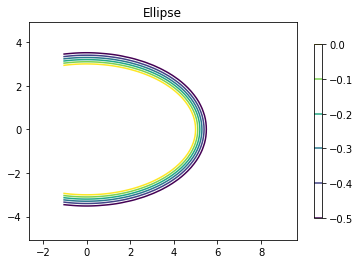

In [11]:
NX = 64
NY = 64
XMIN = 0.0
XMAX = 7.0
YMIN = -4.0
YMAX = 4.0
k = 2 

x,y = torch_grid(XMIN,XMAX,YMIN,YMAX,NX,NY)
x.requires_grad = True
y.requires_grad = True

wk = lambda p: normalize(ellipse, p, k)

#x = torch.tensor([[1.0, 2.0]], requires_grad=True)
#wkx = wk(x)
#print(wkx)

f = torch_sampling(wk, x, y)
show_contour_lines(x, y, f)